In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from torch.autograd import Variable
from numpy import pi

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,128)
        self.fc2 = nn.Linear(128,1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

def u(x):
    y = torch.sin(x)
    return y

def loss_fn(net, x_data):
    return (net(x_data) - u(x_data)).pow(2).mean() #测试拟合函数


In [24]:
#训练
epochs = 1000
learning_rate = 1e-3
x_train = torch.unsqueeze(torch.linspace(0,pi,64),dim=1) #生成从 0 到 π 的 64 个等间距点
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

for i in range(epochs):
    x = x_train        #full batch
    loss = loss_fn(net, x)
    optimizer.zero_grad() # 清空梯度缓存，防止梯度累积
    loss.backward() # 执行反向传播，计算梯度
    optimizer.step() # 根据梯度更新模型参数
    loss_history.append(loss.item())
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1,loss.item()), end='', flush=True)

epoch 1000 MSE loss = 0.000962

In [21]:
#测试
x_test = torch.unsqueeze(torch.linspace(0,pi,100),dim=1)
y_test = u(x_test)
y_predict = net(x_test)

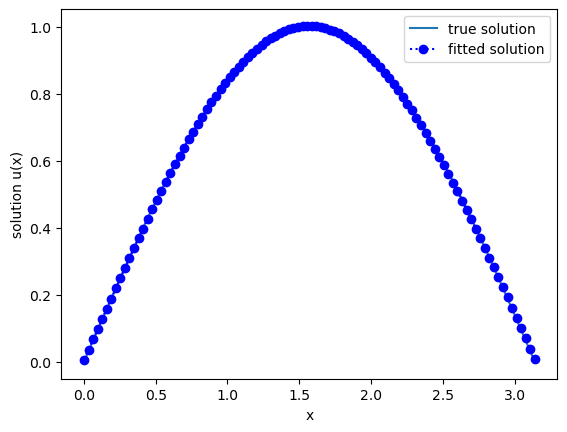

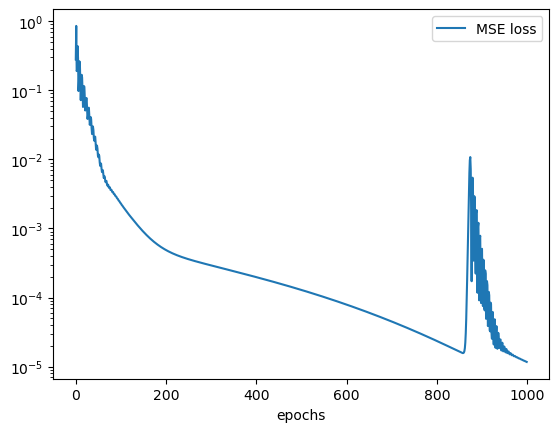

In [23]:
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()


plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

# Problem 1

在(0,π)之外的区域预测结果如何，需要如何改进才能预测准?

In [25]:
x_test = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1)
y_test = u(x_test)
y_predict = net(x_test)

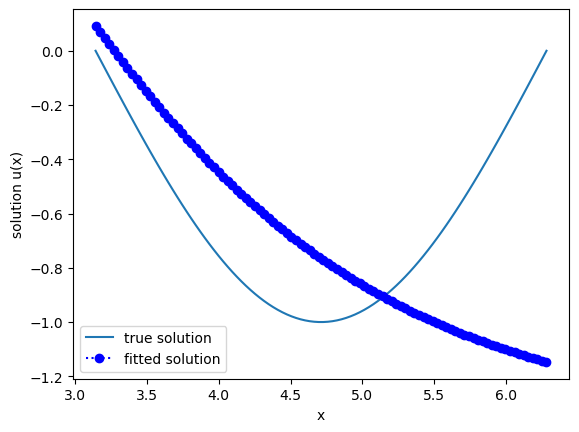

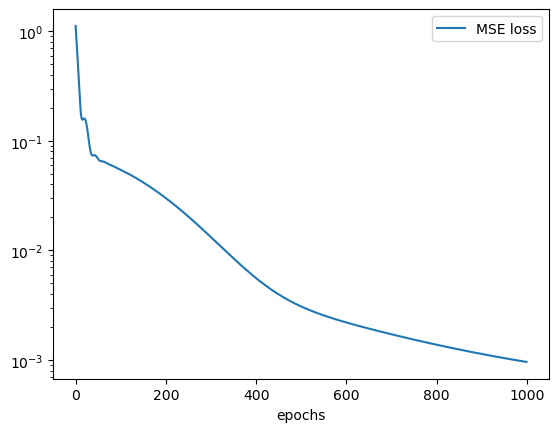

In [26]:
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()


plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

# solution 1

由于之前训练的模型仅仅使用了(0,pi)的数据，未使用(pi,2 * pi)的数据。因此，必须使用(pi,2*pi)的数据重新训练一次

In [32]:
# train agian

#训练
epochs = 1000
learning_rate = 1e-3
x_train = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1) #生成从 pi 到 2 * pi 的 64 个等间距点
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

for i in range(epochs):
    x = x_train        #full batch
    loss = loss_fn(net, x)
    optimizer.zero_grad() # 清空梯度缓存，防止梯度累积
    loss.backward() # 执行反向传播，计算梯度
    optimizer.step() # 根据梯度更新模型参数
    loss_history.append(loss.item())
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1,loss.item()), end='', flush=True)

epoch 1000 MSE loss = 0.001137

In [33]:
x_test = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1)
y_test = u(x_test)
y_predict = net(x_test)

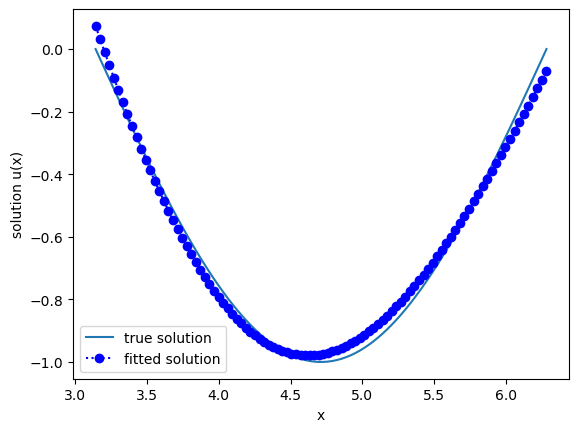

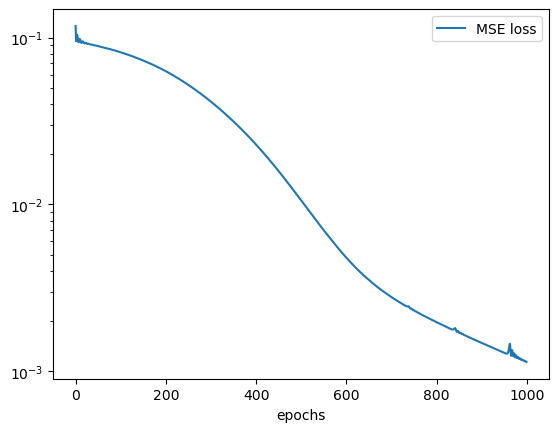

In [34]:
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()


plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

# problem 2
如何改进训练集，用不同batch而非full batch?


# solution 2
使用mini-batch,8,16,32,64之间调整
数值越小，loss减小的速度越快，但后期数值不稳定

In [46]:
# use batch
from torch.utils.data import DataLoader, TensorDataset

In [81]:
epochs = 1000
learning_rate = 1e-3
batch_size = 16

x_train = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1) 
dataset = TensorDataset(x_train, u(x_train)) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 每次迭代返回一个 batch

In [82]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

In [83]:
# mini-batch
for i in range(epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader:
        loss = loss_fn(net, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_batch.shape[0]
    
    avg_epoch_loss = epoch_loss / len(dataset)
    loss_history.append(avg_epoch_loss)
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1, avg_epoch_loss), end='', flush=True)

epoch 1000 MSE loss = 0.000421

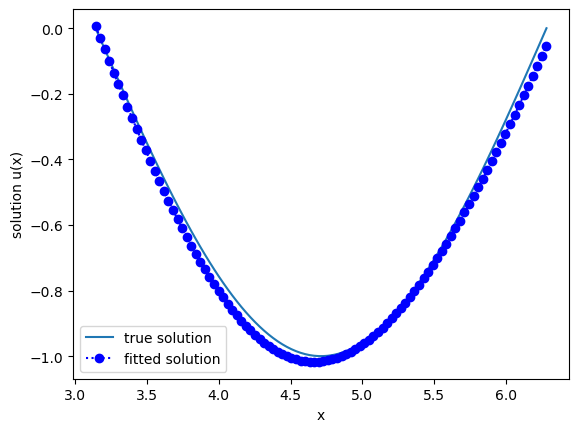

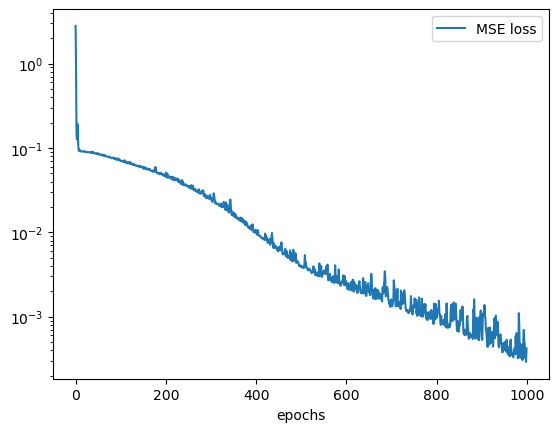

In [84]:
x_test = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1)
y_test = u(x_test)
y_predict = net(x_test)
plt.figure(1)
plt.plot(x_test, y_test, label='true solution')
plt.plot(x_test, y_predict.detach(), 'bo:', label='fitted solution')
plt.xlabel('x')
plt.ylabel('solution u(x)')
plt.legend()
plt.show()
plt.figure(2)
plt.plot(loss_history,label='MSE loss')
plt.xlabel('epochs')
plt.yscale("log")
plt.legend()
plt.show()

# problem 3
如何调用不同优化器，设置学习率变化

In [101]:
# load
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR

epochs = 1000
learning_rate = 1e-3
batch_size = 16

x_train = torch.unsqueeze(torch.linspace(pi,2 * pi,100),dim=1) 
dataset = TensorDataset(x_train, u(x_train)) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  # 每次迭代返回一个 batch
net = Net()

#optimizer = optim.SGD(net.parameters(), lr=learning_rate)            # SGD
optimizer = optim.Adam(net.parameters(), lr=learning_rate)           # Adam
#optimizer = optim.AdamW(net.parameters(), lr=learning_rate)          # AdamW
#optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)        # RMSprop
#optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)         # Adagrad

#scheduler = StepLR(optimizer, step_size=100, gamma=0.5)              # 每100轮学习率 ×0.5
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)         # 当 loss 不下降时降低学习率
#scheduler = ExponentialLR(optimizer, gamma=0.99)                      # 每轮学习率 ×0.99

loss_history = []

#  mini-batch
for i in range(epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader:
        loss = loss_fn(net, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.shape[0]

    avg_epoch_loss = epoch_loss / len(dataset)
    loss_history.append(avg_epoch_loss)
    #scheduler.step() # update lr  // 
    scheduler.step(avg_epoch_loss)
    
    print('\repoch {:d} MSE loss = {:.6f}'.format(i+1, avg_epoch_loss), end='', flush=True)

epoch 1000 MSE loss = 0.005207

# problem 4
如何调用一般形式的神经网络，以及损失函数

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from numpy import pi

# general train fuction
def train_model(
    model,
    dataloader,
    loss_fn,
    optimizer,
    scheduler=None,
    epochs=1000,
    device='cpu'
):
    """
    general train function
    
    param：
    - model: nn
    - dataloader: data loader
    - loss_fn: loss function（param: model , batch ）
    - optimizer: optimizer
    - scheduler: learning rate scheduler（optional）
    - epochs: training epochs
    - device: 'cpu' or 'cuda'
    """
    model.to(device)
    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()  # set to training model

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # forward
            loss = loss_fn(model, x_batch, y_batch)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x_batch.shape[0]

        avg_loss = epoch_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)

        # update lr
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_loss)
            else:
                scheduler.step()

        print(f'\repoch {epoch+1} loss = {avg_loss:.6f}', end='', flush=True)

    return loss_history

# general net class
class GeneralNet(nn.Module):
    def __init__(self, input_dim=1, hidden_layers=[128], output_dim=1, activation='tanh'):
        """
        general nn structure
        
        param：
        - input_dim: input dim
        - hidden_layers: e.g. [128, 64, 32]
        - output_dim: output dim
        - activation: active function types
        """
        super(GeneralNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # set hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            prev_dim = hidden_dim
            
        # output
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


def general_loss_fn(model, x, y_true, loss_type='mse'):
    """
    loss fn
    
    param：
    - model: model
    - x: input
    - y_true: true label
    - loss_type: loss function type
    """
    y_pred = model(x)
    
    if loss_type == 'mse':
        return nn.functional.mse_loss(y_pred, y_true)
    elif loss_type == 'mae':
        return nn.functional.l1_loss(y_pred, y_true)
    elif loss_type == 'smooth_l1':
        return nn.functional.smooth_l1_loss(y_pred, y_true)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

if __name__ == "__main__":
    # 1. define model
    net = GeneralNet(input_dim=1, hidden_layers=[128, 128,128], output_dim=1, activation='relu')

    # 2. define y = f(x)
    def u(x):
        return torch.sin(x)

    # 3. prepare data
    x_train = torch.unsqueeze(torch.linspace(0, pi, 64), dim=1)
    dataset = TensorDataset(x_train, u(x_train))
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # 4. define optimizer and scheduler
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

    # 5. loss
    loss_history = train_model(
        model=net,
        dataloader=dataloader,
        loss_fn=lambda model, x, y: general_loss_fn(model, x, y, 'mse'),
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=1000
    )

    print("\nTraining completed!")

epoch 1000 loss = 0.000000
Training completed!


# problem 5
如何拟合二维函数或更高维函数？


# solution 5
使用前面类似的方法，拟合一个二维函数，并在后面给出loss图像以及拟合函数可视化图

f(u,v)=u^2+3uv+v^3

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import time  # 添加时间模块

# 通用网络类
class GeneralNet(nn.Module):
    def __init__(self, input_dim=1, hidden_layers=[128], output_dim=1, activation='tanh'):
        super(GeneralNet, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # 构建隐藏层
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            prev_dim = hidden_dim
            
        # 输出层
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# 通用训练函数
def train_model(
    model,
    dataloader,
    loss_fn,
    optimizer,
    scheduler=None,
    epochs=1000,
    device='cpu'
):
    model.to(device)
    loss_history = []
    
    # 记录训练时间
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0.0
        model.train()

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # 前向传播
            loss = loss_fn(model, x_batch, y_batch)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x_batch.shape[0]

        avg_loss = epoch_loss / len(dataloader.dataset)
        loss_history.append(avg_loss)

        # 更新学习率
        if scheduler:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_loss)
            else:
                scheduler.step()

        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f'epoch {epoch+1} loss = {avg_loss:.6f}')

    # 计算训练耗时
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    return loss_history, train_time

# 通用损失函数
def general_loss_fn(model, x, y_true, loss_type='mse'):
    y_pred = model(x)
    
    if loss_type == 'mse':
        return nn.functional.mse_loss(y_pred, y_true)
    elif loss_type == 'mae':
        return nn.functional.l1_loss(y_pred, y_true)
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

# 定义目标函数 f(u,v) = u^2 + 3uv + v^3
def target_function(x):
    u, v = x[:, 0], x[:, 1]
    return (u**2 + 3*u*v + v**3).unsqueeze 生成测试网格(1)

# 
    u =生成训练数据
 torch.linspace(u_range[0], udef generate_2_range[1],d_data num_points)
   (u_min, u v = torch.linspace_max, v_min(v_range[0], v_range, v_max, num_points):
    u[1], num_points)
    = torch.linspace(u U, V =_min, u_max, num_points)
    v torch.meshgrid(u, v, indexing='ij = torch.linspace(v_min, v')
    x_test_max, num_points = torch.stack)
    U,([U.flatten(), V = V.flatten()], dim=1 torch.meshgrid(u, v, indexing).to(device)
    
    #='ij')
    x_train = torch.stack([ 计算真实值和预测值U.flatten(), V
    with torch.no_grad():
.flatten()], dim=1)
    y_train =        y_true = target target_function(x_function(x_train)
_test)
        y_pred = model(x    return x_train, y_train

#_test)
    
    # 可视化函数 转换为numpy用于绘图

def visualize_2d_results    U_np =(model, loss_history, u_range U.numpy=(-2, ()
    V_np2), v_range = V.numpy()
    y=(-2, 2), num_points=50, device='cpu'):
    start_time = time.time()  # 记录可视化开始时间
    
    model.to(device)
    model.eval_true_np = y()
    
    #_true.cpu().numpy().reshape(U.shape)
    y_pred_np = y_pred.cpu().numpy().reshape(U.shape)
    
    # 创建图形
    fig = plt.figure(figsize=(15, 5))
    
    # 真实函数可视化
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(U_np, V_np, y_true_np, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('u')
    ax1.set_ylabel('v')
    ax1.set_zlabel('f(u,v)')
    ax1.set_title('True Function: f(u,v) = u² + 3uv + v³')
    fig.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # 预测函数可视化
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(U_np, V_np, y_pred_np, cmap='viridis', alpha=0.8)
    ax2.set_xlabel('u')
    ax2.set_ylabel('v')
    ax2.set_zlabel('f(u,v)')
    ax2.set_title('Fitted Function')
    fig.colorbar(surf2, ax=ax2, shrink=0.5)
    
    # 损失曲线
    ax3 = fig.add_subplot(133)
    ax3.plot(loss_history)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_yscale('log')
    ax3.set_title('Training Loss')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 计算误差
    mse = ((y_pred_np - y_true_np) ** 2).mean()
    mae = abs(y_pred_np - y_true_np).mean()
    
    # 计算可视化耗时
    vis_time = time.time() - start_time
    print(f"Visualization completed in {vis_time:.2f} seconds")
    
    print(f"Test MSE: {mse:.6f}")
    print(f"Test MAE: {mae:.6f}")
    
    return mse, mae, vis_time

# 主训练流程
if __name__ == "__main__":
    # 记录总耗时
    total_start_time = time.time()
    
    # 设置设备
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # 生成训练数据
    x_train, y_train = generate_2d_data(-2, 2, -2, 2, 20)  # 20x20网格
    dataset = TensorDataset(x_train, y_train)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 创建模型
    net = GeneralNet(input_dim=2, hidden_layers=[128, 64, 32], output_dim=1, activation='tanh')
    
    # 设置优化器
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
    
    # 训练模型
    print("Training 2D function approximator...")
    loss_history, train_time = train_model(
        model=net,
        dataloader=dataloader,
        loss_fn=lambda model, x, y: general_loss_fn(model, x, y, 'mse'),
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=2000,
        device=device
    )
    
    # 可视化结果
    print("\nVisualizing results...")
    mse, mae, vis_time1 = visualize_2d_results(
        model=net,
        loss_history=loss_history,
        u_range=(-2, 2),
        v_range=(-2, 2),
        num_points=50,
        device=device
    )
    
    # 测试外推能力
    print("\nTesting extrapolation (u,v in [-3,3]):")
    mse_ext, mae_ext, vis_time2 = visualize_2d_results(
        model=net,
        loss_history=loss_history,
        u_range=(-3, 3),
        v_range=(-3, 3),
        num_points=50,
        device=device
    )
    
    # 计算总耗时
    total_time = time.time() - total_start_time
    
    # 输出时间统计
    print("\n" + "="*50)
    print("TIME STATISTICS")
    print("="*50)
    print(f"Training time:     {train_time:.2f} seconds")
    print(f"Visualization 1:   {vis_time1:.2f} seconds")
    print(f"Visualization 2:   {vis_time2:.2f} seconds")
    print("-"*50)
    print(f"Total time:        {total_time:.2f} seconds")
    print("="*50)

IndentationError: unindent does not match any outer indentation level (<string>, line 107)